# Lab 2: Stochastic Gradient Descent

The goal of this lab session is to code an optimization algorithm that optimzes the penalized loss function of the logistic regression model.

You have to send the filled notebook named **"L2_familyname1_familyname2.ipynb"** by email to *violeta.roizman@l2s.centralesupelec.fr* by October 10, 2018. Please put **"AML-L2"** in the subject. 

We begin with the standard imports:

In [2]:
%matplotlib inline
import math
import sys
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd
from gc import collect

We are going to use the W8A dataset, a tidy and binarized version of https://archive.ics.uci.edu/ml/datasets/adult (check it out for more details). 
In this dataset we have census data to predict if the income of an adult exceeds $50K/yr (1 or -1).  

In [4]:
w8a_train = pd.read_csv("w8a.csv", sep=";", header=None)
w8a_train_x = np.array(w8a_train.iloc[:, :-1])
w8a_train_y = np.array(w8a_train.iloc[:, -1])


w8a_test  = pd.read_csv("w8a_t.csv", sep=";", header=None)
w8a_test_x = np.array(w8a_test.iloc[:, :-1])
w8a_test_y = np.array(w8a_test.iloc[:, -1])

print("shape: ", w8a_train.shape)
w8a_train.head()

shape:  (49749, 301)


,0,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,300
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-1


In [5]:
#we don't need these variables so we're gonna clean the memory
del w8a_train, w8a_test
collect()

0

## Logistic Regression



Today we’ll be moving from linear regression to logistic regression, one of the simplest ways to deal with a classification problem. Instead of fitting a line, logistic regression models the probability that the outcome is 1 given the value of the predictor. In order to do this we need a function that transforms our predictor variable to a value between 0 and 1. Lots of functions can do that, but the logistic function is the most common choice:

$$f(z) = \frac{1}{1+\exp{-z}}.$$

To predict the class of our observations we'll have to minimize the corresponding loss function and as we are in a high-dimensional context we'll add an $l_2$ regularization to the model:

$$L(\textbf{w}) = \sum_{i=1}^n log(1+\exp(-y_i\textbf{w}^Tx_i))+\frac{\lambda}{2} \| \textbf{w} \|^2,$$

where $x_i$ is the vector of features for the observation $i$ and $y_i \in \{-1, 1\}$ is the class label.  


We first use the `sklearn` implementation:

In [6]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(penalty="l2", C=1.0)
model.fit(w8a_train_x, w8a_train_y)
y_pred = model.predict(w8a_test_x)

and we compute the accuracy score to evaluate the model performance:

In [7]:
from sklearn.metrics import accuracy_score
accuracy_score(w8a_test_y, y_pred)

0.9856865761487525

### Assignment

Implement from scratch your own logistic regression model with stochastic gradient descent. 

- Fill in the classes

- Display the evolution of the cost function along iterations. Do this for several strategies for the setting of the learning rate

- Try the different acceleration strategies

- Train the model with the training set and evaluate its performance in the test set

## Answer

We first define a class of utilities for our optimizer classes to inherit from

In [8]:
class GD_Utilities():
    
    """"
        Class of utilities to inherit from
    
    beta_history: list of np.array
        the list of all points where f has been evaluated
    f_history: list of np.array
        the list of all evaluated f
        
    """
        
    def plot_f_values(self):
        """Plot the historical f values once optimization is complete.          
        """
        plt.plot(self.f_history, label= self.acceleration + ', lr:' + str(self.lr))
        plt.legend(loc = 1)
            
    def print_result(self):
        """ Print out result once optimization is complete.        
        """
        sys.stdout.write(" === Result for : " + self.acceleration + " ===\n")
        #sys.stdout.write("Beta: " + str(self.beta) +'\n')
        sys.stdout.write("f(beta) = " + str(self.f(self.beta)) + '\n')
    

For purely esthetic reasons, we define a Class for both variants because the parameters needed for the algorithms differ. 

We're gonna define the SAG/SAGA algorithm as purely stochastic algorithms, so there will be no mini-batch variant.

### Gradient Descent : Stochastic/Mini_batch, Beta Averaging, Gradient Averaging, MOMENTUM and ADAGRAD

In [9]:
class StochasticGradientDescentOptimizer(GD_Utilities):
    """ Class for optimization by gradient descent.
    
    Attributes:
    -----------
    f: function
        the function to optimize
    beta: np.array
        the point where the function is currently being evaluated
    lr: float
        the learning rate
    acceleration: string 
        name of the aceleration strategy, can be none, beta_average or grad_average

    """
    def __init__(self, f , start, lr=1e-1, acceleration="none", momentum_coef = 0.8, epsilon = 1e-8, decay_exp = 0.0):
        """     
        Parameters:
        -----------
        f: function
            the function to optimize 
        start: np.array
            the starting point, at which we begin our search
        lr: float
            the learning rate
        acceleration: string
            name of the aceleration strategy
        """
        # Store the parameters as attributes
        self.f      = f
        self.beta   = start
        self.lr     = lr
        self.decay_exp = decay_exp
        self.acceleration  = acceleration
        
        self.grad_average = np.zeros_like(start)
        
        #adagrad params
        self.grad_l2 = np.zeros_like(start)
        self.epsilon = epsilon
        
        #momentum params
        self.momentum_coef = momentum_coef
        self.momentum = np.zeros_like(start) # momentum acceleration
        
        
        # Stored values that will be needed through optimisation
        self.optimizer_steps = 1
        
        # Save history as attributes
        self.beta_history = [start]
        self.f_history = [f(start)]    
    
    
    def optimize_step(self, fprime):
        """Use one step of the stochastic gradient descent optimiser to optimise f.        
        Parameters:
        -----------
        fprime: function
            the batch fprime to update the beta with.
        """
        
        if self.acceleration == "none":
            
            self.beta = self.beta - (self.lr/pow(self.optimizer_steps, self.decay_exp))*fprime(self.beta)
            self.f_history.append(self.f(self.beta))
            self.beta_history.append(self.beta)
            self.optimizer_steps += 1
        
        elif self.acceleration == "beta_average":
            
            to_average = self.beta - (self.lr/pow(self.optimizer_steps, self.decay_exp))*fprime(self.beta)
            self.beta = (1 - 1/(self.optimizer_steps))* self.beta + (1/(self.optimizer_steps))* to_average
            self.f_history.append(self.f(self.beta))
            self.beta_history.append(self.beta)
            self.optimizer_steps += 1
        
        elif self.acceleration == "grad_average":
            
            self.grad_average = (1 - 1/(self.optimizer_steps))* self.grad_average + (1/(self.optimizer_steps))*fprime(self.beta)
            self.beta = self.beta - (self.lr/pow(self.optimizer_steps, self.decay_exp))*self.grad_average
            self.f_history.append(self.f(self.beta))
            self.beta_history.append(self.beta)
            self.optimizer_steps += 1
        
        elif self.acceleration == "adagrad":
            self.grad_l2 += fprime(self.beta)**2
            self.beta = self.beta - (self.lr/pow(self.optimizer_steps, self.decay_exp))*fprime(self.beta)*((self.epsilon + self.grad_l2)**(-0.5))
            self.f_history.append(self.f(self.beta))
            self.beta_history.append(self.beta)
            self.optimizer_steps += 1
        
        elif self.acceleration == "momentum":
            cache = self.beta
            self.beta = self.beta - (self.lr/pow(self.optimizer_steps, self.decay_exp))*fprime(self.beta) + self.momentum_coef*(self.momentum)
            self.momentum = self.beta - cache
            self.f_history.append(self.f(self.beta))
            self.beta_history.append(self.beta)
            self.optimizer_steps += 1
        else :
            print('please use an existing acceleration')
        

## Stochastic Gradient Averaging : SAG and SAGA

In [24]:
class StochasticGradientAveragingOptimizer(GD_Utilities):
    """ Class for optimization by SAG/SAGA for batch_size=1
    
    Attributes:
    -----------
    f: function
        the function to optimize
    beta: np.array
        the point where the function is currently being evaluated
    lr: float
        the learning rate
    acceleration: string 
        name of the aceleration strategy

    """
    def __init__(self, f , start, start_grad_memory, lr=1e-1, decay_exp= 0.0, acceleration="sag"):
        """     
        Parameters:
        -----------
        f: function
            the function to optimize 
        fprime: function
            the function's gradient
        start: np.array
            the starting point, at which we begin our search
        lr: float
            the learning rate
        acceleration: string
            name of the aceleration strategy, can be sag or saga
        n : size of the data
            needed for the SAG/SAGA algorithm
            
        """
        # Store the parameters as attributes
        self.f      = f
        self.beta   = start
        self.lr     = lr
        self.acceleration  = acceleration
        self.decay_exp = decay_exp
        
        # Stored values that will be needed through optimisation
        
        self.optimizer_steps = 1
        
        self.sag_average = np.mean(start_grad_memory, axis = 0) # sag_averaging acceleration
        self.sag_memory = start_grad_memory #memory to store all the previous gradients shape (n,p+1)
        self.data_size = len(start_grad_memory)
        
        # Save history as attributes
        self.beta_history = [start]
        self.f_history = [f(start)]    
    
    
    def optimize_step(self, fprime, index =1):
        """Use one step of the stochastic gradient descent optimiser to optimise f.        
        Parameters:
        -----------
        fprime: function
            the batch fprime to update the beta with.
        
        """
        
        if self.acceleration == "sag":
            self.sag_average = (1/self.data_size)*(fprime(self.beta) - self.sag_memory[index]) + self.sag_average
            self.beta = self.beta - (self.lr/pow(self.optimizer_steps, self.decay_exp))*(self.sag_average)
            self.sag_memory[index] = fprime(self.beta)
            
            self.f_history.append(self.f(self.beta))
            self.beta_history.append(self.beta)
            self.optimizer_steps += 1
        
        elif self.acceleration == "saga":
            
            self.beta = self.beta - (self.lr/pow(self.optimizer_steps, self.decay_exp))*(fprime(self.beta) - self.sag_memory[index] + self.sag_average)
            self.sag_average = (1/self.data_size)*(fprime(self.beta) - self.sag_memory[index]) + self.sag_average
            self.sag_memory[index] = fprime(self.beta)
            
            self.f_history.append(self.f(self.beta))
            self.beta_history.append(self.beta)
            self.optimizer_steps += 1
            
            

## Logistic Regression

In [25]:
class LogisticRegression():
    """ Class for logistic regression:
    
    Attributes:
    -----------
    coef_: 1-dimensional np.array
        coefficients 
    alpha_: float
        regularization parameter
    lr: float
        the learning rate
    bsize: integer
        size of the mini-batch
    acceleration: string
        name of the aceleration strategy for a given strategy
    """
    
    def __init__(self, alpha, acceleration = 'none', bsize=32, lr=1e-1, decay_exp=0.0, max_iter=100, momentum_coef=0.8):
        
        self.coef_  = None
        self.alpha_ = alpha
        self.lr     = lr
        self.bsize  = bsize
        self.acceleration  = acceleration
        self.max_iter = max_iter
        self.decay_exp = decay_exp
        
        # Momentum strategy dependent parameter
        self.momentum_coef = momentum_coef
        
        
    def fit(self, X, y):
        """ Fit the data (X, y).
    
        Parameters:
        -----------
        X: (num_samples, num_features) np.array
            Design matrix
             Output vector
        
        Note:
        -----
        Updates self.coef_
        """
        
        n,p = X.shape
        
        X_aug = np.concatenate((np.ones((n,1)), np.array(X)), axis=1)
        
        L = - y.reshape(-1,1)*X_aug
        
        def f_lr(beta):            
            """ 
            Returns the logistic loss.        
            """
            n = len(L)
            return np.mean(np.log(1 + np.exp(np.matmul(L, beta)))) + 0.5*self.alpha_*np.dot(beta.T,beta)
        
        
        rng = np.random.RandomState(1)
        
        beta_start = rng.normal(0, 1e-3, p+1)
        
        #define the split function
        def split(n,batch_size):
            if batch_size == 1 : return rng.permutation(np.arange(n))
            else : return np.array([rng.permutation(np.arange(n))[i*batch_size: (i+1)*batch_size] for i in range(math.ceil(n/batch_size))])
        
        if self.acceleration not in {'sag', 'saga'}:
            
            #define the optimizer
            
            optimizer = StochasticGradientDescentOptimizer(f_lr, beta_start, lr= self.lr, acceleration=self.acceleration, 
                                                           decay_exp = self.decay_exp, momentum_coef= self.momentum_coef)
            
            #generate the splits
            indexes = split(n, self.bsize)
            bn, cycle = 0, len(indexes)
            
            for t in range(1, self.max_iter+1):
                
                L_batch = L[indexes[bn]]

                fprime_lr = lambda beta : np.dot(L_batch.T, 1/(1+ np.exp(-np.dot(L_batch, beta))))*(1/self.bsize) + self.alpha_*beta

                optimizer.optimize_step(fprime_lr)
                
                bn += 1
                
                if bn == cycle : bn =0
        
        else :
            
            start_grad_memory = (L * (1/(1 + np.exp(-np.matmul(L,beta_start)))).reshape(-1,1)) + self.alpha_*beta_start
            
            optimizer = StochasticGradientAveragingOptimizer(f_lr, beta_start, start_grad_memory= start_grad_memory, lr= self.lr, 
                                                             decay_exp = self.decay_exp, acceleration=self.acceleration)
        
            for t in range(1, self.max_iter+1):
            
                index = rng.randint(0, n)
                L_batch = L[index]
                fprime_lr = lambda beta : np.dot(L_batch.T, 1/(1+ np.exp(-np.dot(L_batch, beta)))) + self.alpha_*beta

                optimizer.optimize_step(fprime_lr, index)
        
        self.coef_ = optimizer.beta
        optimizer.plot_f_values()
        optimizer.print_result()
        
        
        
    def predict_proba(self, X):
        """ Make binary predictions for data X.
    
        Parameters:
        -----------
        X: (num_samples, num_features) np.array
            Design matrix
        
        Returns:
        -----
        y_pred: (num_samples, ) np.array
            Predictions (0 or 1)
        """
        n,p = X.shape
        X_aug = np.concatenate([np.ones((n,1)), X], axis=1)
        return 1/(1+ np.exp(-np.dot(X_aug, self.coef_)))
    
    
    def predict(self, X):
        return np.where(self.predict_proba(X)>0.5, 1, -1)

### Evolution of the loss function wrt the learning rate

First, let's try to see the impact of the learning rate without any decay on the stochastic gradient descent 

 === Result for : none ===
f(beta) = 0.13409165178280888
 === Result for : none ===
f(beta) = 0.15855159331994106
 === Result for : none ===
f(beta) = 0.301105516506877


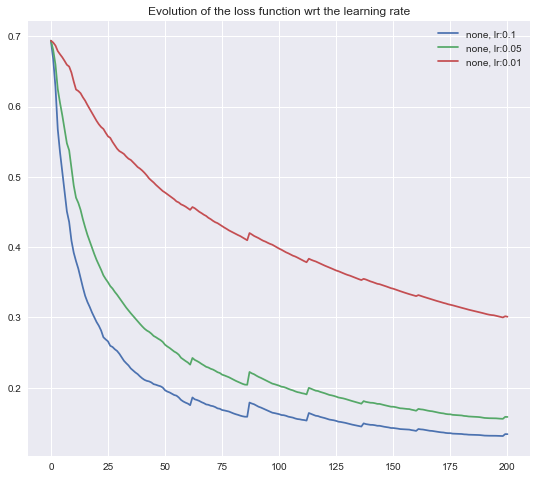

In [53]:
lrates = [0.1, 0.05, 0.01]

plt.figure(figsize=(9,8))

for lr in lrates : 
    sgd_logistic = LogisticRegression(alpha=0.0, bsize=1, lr=lr, max_iter=200, acceleration="none", decay_exp= 0.0)
    sgd_logistic.fit(w8a_train_x, w8a_train_y)

plt.title("Evolution of the loss function wrt the learning rate")
plt.show()

Now, for a decay_exp of 1 :

 === Result for : none ===
f(beta) = 0.47796301904604194
 === Result for : none ===
f(beta) = 0.5639961861182414
 === Result for : none ===
f(beta) = 0.6630101179036195


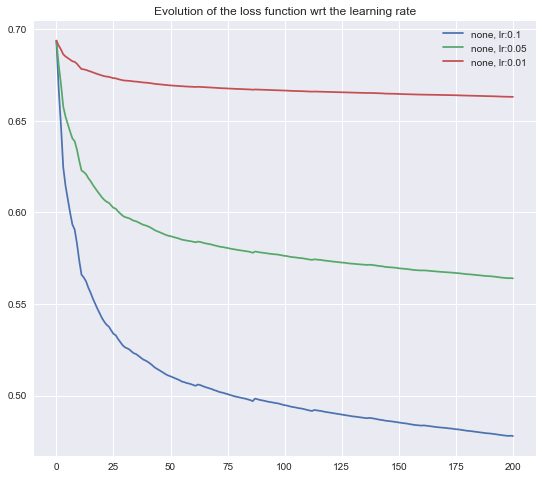

In [54]:
lrates = [0.1, 0.05, 0.01]

plt.figure(figsize=(9,8))

for lr in lrates : 
    sgd_logistic = LogisticRegression(alpha=0.0, bsize=1, lr=lr, max_iter=200, acceleration="none", decay_exp= 1.0)
    sgd_logistic.fit(w8a_train_x, w8a_train_y)

plt.title("Evolution of the loss function wrt the learning rate")
plt.show()

After some basic tuning of the lr, batch size and decay_exp we got :

 === Result for : none ===
f(beta) = 0.08974080908574963


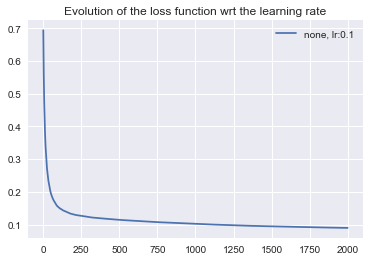

In [125]:
sgd_logistic = LogisticRegression(alpha=0.0, bsize=64, lr=0.1, max_iter=2000, acceleration="none", decay_exp= 0.0)
sgd_logistic.fit(w8a_train_x, w8a_train_y)

plt.title("Evolution of the loss function wrt the learning rate")
plt.show()

Let's compare the acceleration strategies for the stochastic/mini_batch gradient descent

 === Result for : none ===
f(beta) = 0.11903311221886148
 === Result for : grad_average ===
f(beta) = 0.12265243792831106
 === Result for : beta_average ===
f(beta) = 0.26063535754353084


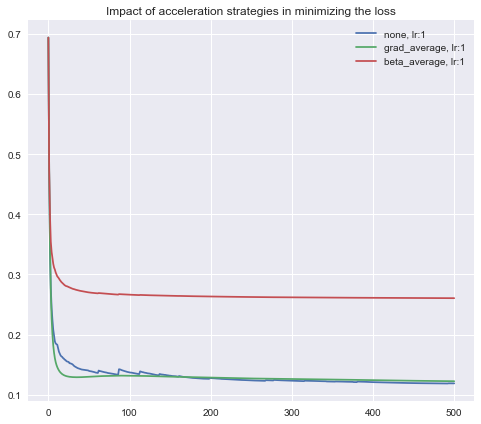

In [126]:
accelerations = ['none', 'grad_average', 'beta_average']

plt.figure(figsize=(8,7))
for acceleration in accelerations : 
    sgd_strat = LogisticRegression(alpha=0, bsize=1, lr=1, max_iter=500, acceleration=acceleration, decay_exp=0.5)
    sgd_strat.fit(w8a_train_x, w8a_train_y)


plt.title("Impact of acceleration strategies in minimizing the loss")
plt.show()

We can see that the gradient averaging method reaches a minimum faster, but the stochastic gradient descent converges to a better minima after 500 iterations

Now let's see how the SAG/SAGA algorithms behave

 === Result for : sag ===
f(beta) = 0.13674545259656004
 === Result for : saga ===
f(beta) = 0.12739266365816232


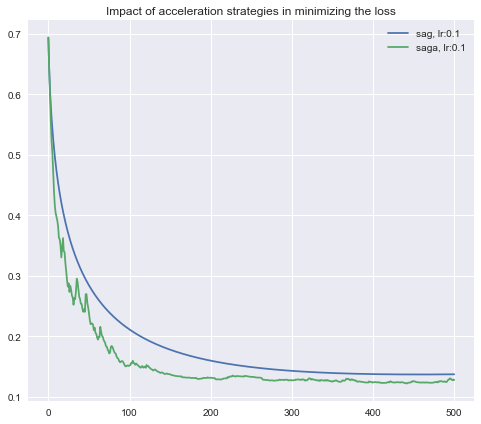

In [127]:
plt.figure(figsize=(8,7))

sag = LogisticRegression(alpha=0.0, lr=0.1, max_iter=500, acceleration='sag', decay_exp=0.5)
sag.fit(w8a_train_x, w8a_train_y)

saga = LogisticRegression(alpha=0.0, lr=0.1, max_iter=500, acceleration='saga', decay_exp =0)
saga.fit(w8a_train_x, w8a_train_y)


plt.title("Impact of acceleration strategies in minimizing the loss")
plt.show()

The SAGA algorithm reaches a plateau faster than the sag, and it's minima is better. We know that we can't compare the speed of both algorithms because we took a learning rate of 1 for the saga and 0.1 for the sag, but we tried the same lr = 1 for the sag and it didn't converge. (you can try)

Finally, let's compare the momentum gradient descent algorithm and Adagrad so we can choose the best optimizers to test on the test set

 === Result for : momentum ===
f(beta) = 0.061249124997979625
 === Result for : adagrad ===
f(beta) = 0.047710235483948066


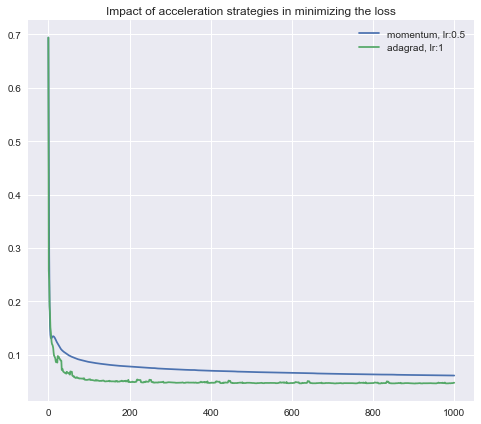

In [128]:
plt.figure(figsize=(8,7))

momentum = LogisticRegression(alpha=0.0, bsize =512, lr=0.5, max_iter=1000, acceleration='momentum', momentum_coef=0.8)
momentum.fit(w8a_train_x, w8a_train_y)


#for Adagrad, we chose a bunch (256) of observations in the batch so as to estimate the gradient better
#with no decay because we already divide by the the root of the cumulative sum of  of the gradient squared
adagrad = LogisticRegression(alpha=0, bsize = 256, lr=1, max_iter=1000, acceleration='adagrad')
adagrad.fit(w8a_train_x, w8a_train_y)


plt.title("Impact of acceleration strategies in minimizing the loss")
plt.show()


For the sake of simplicity, we're gonna choose 4 optimizers implemented which are based on the minimization of the global loss function : a simple mini-batch SGD, Adagrad, Momentum and SAGA.

## Results and Discussion

First let's just take a peek on the distribution of our response variable

In [129]:
np.mean(w8a_test_y <0)

0.9696341381847368

The response variable is clearly unbalanced so the accuracy metric is not suitable for our problem, but it's okay let's measure the accuracy of our 4 best classifiers and compare it to the sklearn implementation

In [130]:
y_saga, y_momentum, y_adagrad, y_sgd = saga.predict(w8a_test_x), momentum.predict(w8a_test_x), adagrad.predict(w8a_test_x), sgd_logistic.predict(w8a_test_x)

print("Mini batch SGD accuracy is :", accuracy_score(w8a_test_y, y_sgd))
print("SAGA accuracy is :", accuracy_score(w8a_test_y, y_saga))
print("Momentum accuracy is :", accuracy_score(w8a_test_y, y_momentum))
print("Adagrad accuracy is :", accuracy_score(w8a_test_y, y_adagrad ))
print("Sklearn accuracy is :", accuracy_score(w8a_test_y, y_pred))

Mini batch SGD accuracy is : 0.971506922613872
SAGA accuracy is : 0.9697679085011036
Momentum accuracy is : 0.9812721557086482
Adagrad accuracy is : 0.985753461306936
Sklearn accuracy is : 0.9856865761487525


We can see that the saga behaves like a dummy classifier, it predicts -1 for every observations, but this depends hugely on the treshold we choose ( 0.5 for our case ). that's why we're gonna see the **Area Under ROC Curve** to better compare these models.

In [131]:
from sklearn.metrics import roc_auc_score, roc_curve

In [132]:
def plot_roc(y_pred_proba,y_test, name):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba, pos_label=1)
    plt.plot(fpr,tpr,label='AUC ('+ name +') : ' + str(round(roc_auc_score(y_test, y_pred_proba),3)))
    plt.title("ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()

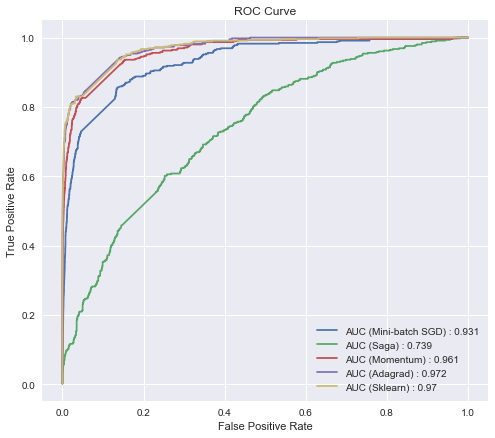

In [133]:
plt.figure(figsize=(8,7))

plot_roc(sgd_logistic.predict_proba(w8a_test_x), w8a_test_y, 'Mini-batch SGD')

plot_roc(saga.predict_proba(w8a_test_x), w8a_test_y, 'Saga')

plot_roc(momentum.predict_proba(w8a_test_x), w8a_test_y, 'Momentum')

plot_roc(adagrad.predict_proba(w8a_test_x), w8a_test_y, 'Adagrad')

plot_roc(model.predict_proba(w8a_test_x)[:,1], w8a_test_y, 'Sklearn')

plt.show()

Our Adagrad implementation can be compared to the sklearn implementation in terms of performance. Those comparaisons however can't be conclusive because both models ( all the models to be fair, especially the SAGA..) need some hyperparameters tuning if we really want to compare them.